In [1]:
import pandas as pd
import numpy as np

# will make your plot outputs appear and be stored within the notebook
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import plotly.express as px
import plotly.graph_objects as go

import math

In [2]:
# Let's read the excel files where are the prices
mv = pd.read_excel('./file.xlsx', sheet_name= "MV")
price = pd.read_excel('./file.xlsx', sheet_name='Price')
co = pd.read_excel('./file.xlsx', sheet_name= "merged_intensity12")

mv = mv.set_index("Date")
# Let's select the first 5 assets
mv = mv.iloc[:, :5]
# Let's rename the columns
mv.columns = ['1', '2', '3', '4', '5']
co = co.set_index("Date")
# Let's select the first 5 assets
co = co.iloc[:, :5]
# Let's rename the columns
co.columns = ['1', '2', '3', '4', '5']
price = price.set_index("Date")
# Let's select the first 5 assets
price = price.iloc[:, :5]
# Let's rename the columns
price.columns = ['1', '2', '3', '4', '5']

In [3]:
price.head()

,1,2,3,4,5
Date,,,,,
2000-01-31,1858.26,1820.11,177.53,156.25,389.64
2000-02-29,2254.15,1911.12,184.55,153.83,318.75
2000-03-31,2334.75,1866.11,184.16,158.62,311.41
2000-04-30,2336.65,1835.93,171.05,137.27,335.24
2000-05-31,2245.09,1805.22,112.65,148.95,356.91


In [4]:
# Calculate the returns
returns = price.pct_change(axis=0)

# Drop the first row of NaN values and the last row of the price DataFrame
returns = returns.iloc[1:-1]

returns.head()

,1,2,3,4,5
Date,,,,,
2000-02-29,0.213043,0.050002,0.039543,-0.015488,-0.181937
2000-03-31,0.035756,-0.023552,-0.002113,0.031138,-0.023027
2000-04-30,0.000814,-0.016173,-0.071188,-0.134598,0.076523
2000-05-31,-0.039184,-0.016727,-0.341421,0.085088,0.064640
2000-06-30,0.017198,-0.081874,0.070129,0.072038,0.021630


In [5]:
# Let's select 2 years of data
returns_10a = returns.loc["2000-02-29":"2022-12-31",:]

returns_10a.head()

,1,2,3,4,5
Date,,,,,
2000-02-29,0.213043,0.050002,0.039543,-0.015488,-0.181937
2000-03-31,0.035756,-0.023552,-0.002113,0.031138,-0.023027
2000-04-30,0.000814,-0.016173,-0.071188,-0.134598,0.076523
2000-05-31,-0.039184,-0.016727,-0.341421,0.085088,0.064640
2000-06-30,0.017198,-0.081874,0.070129,0.072038,0.021630


In [6]:
returns_10a_y = returns_10a.mean(axis=0)
returns_10a_y

1    0.009312
2    0.011655
3    0.018032
4    0.011143
5    0.014369
dtype: float64

Now that we have our monthly returns, let's calculate our covariances and correlations. We are going to choose our window to be 60 months, so we will have 60 covariance matrices and 60 correlation matrices.

In [7]:
window = 60
Covar = returns_10a.rolling(window).cov().dropna()
Covar.tail()

1         2         3         4         5
Date                                                          
2022-11-30 1  0.023355  0.008794  0.007611  0.007636  0.014898
           2  0.008794  0.027934  0.020802  0.002539  0.004746
           3  0.007611  0.020802  0.031784  0.002024  0.003115
           4  0.007636  0.002539  0.002024  0.008001  0.006675
           5  0.014898  0.004746  0.003115  0.006675  0.014831

In [10]:
# Let's sum the whole column to get the total carbon footprint
carbon_f_a = co.mean(axis=0)
carbon_f_a

1      98.055185
2    1422.441540
3    3421.786570
4      50.817753
5     417.375650
dtype: float64

In [ ]:
# Let's sum the whole column to get the total carbon footprint
carbon_f_y = total_carbon.sum(axis=1)

# Let's plot the Carbon Footprint
carbon_f_y.plot(title="Carbon Footprint")

In [ ]:
#Total of 73 dates which corresponds to the number of covariance matrix to estimate
dates = Covar.index.get_level_values('Date').unique()
# Extract only the date part
date_only = dates.date
date_list = date_only.tolist()
len(dates)

215

## Optimize weighted without carbon constrains

Now that we have the optimization problem 

In [ ]:
# Create an empty dictionary to store results
results_dict_op = {}

w = 2000
#Loop on dates (months 2006-2020)
for date in dates:
    
    #Define the objective function (minimum variance)
    objectiveFunction = lambda x: np.dot(x.T, np.dot(Covar.loc[date], x))
    
    #Set initial weights (equally weighted portfolio)
    numberOfAssets = len(returns_10a.columns)
    x0 = np.ones(numberOfAssets)/numberOfAssets 

    #Our investment has to be positive (long only)
    bounds = tuple((0,1) for x in range(numberOfAssets))

    #Define contraints:
    cons_s = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    
    #Solve the optimization
    results_op = minimize(objectiveFunction, x0, method='SLSQP', constraints=cons_s, bounds=bounds)
    
    # Extract relevant information
    success = results_op.success
    optimal_weights = results_op.x if success else None
    
    # Append results to the dictionary
    results_dict_op[date] = {
        'Success': success,
        'Optimal Weights': optimal_weights,
        'Function Value': results_op.fun
    }

In [ ]:
# Let's create a chart to see the evolution of the function value
# Create a DataFrame from the dictionary
results_df_op = pd.DataFrame.from_dict(results_dict_op, orient='index')

# Let's see the weighted with the lowest function value
optimal_weightes_op = results_df_op['Optimal Weights'].iloc[0]

# Let's plot our weights
optimal_weightes_op

array([1.51051904e-01, 2.73449030e-01, 1.35525272e-18, 3.31032532e-01,
       2.44466533e-01])

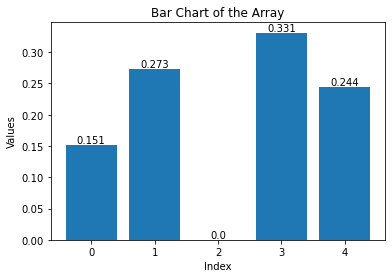

In [ ]:
fig, ax = plt.subplots()
bars = ax.bar(range(len(optimal_weightes_op)), optimal_weightes_op)

# Add labels, title, and grid
ax.set_ylabel('Values')
ax.set_xlabel('Index')
ax.set_title('Bar Chart of the Array')
ax.grid(False)

# Display the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()

In [ ]:
# Now let's multiply the weights by the returns
optimal_returns_op = returns_10a.mul(optimal_weightes_op, axis=1)

# Let's sum the returns over time
optimal_returns_op = optimal_returns_op.median(axis=1)

# Annualized average return
#mean_monthly_return = monthly_return_portfolio.mean()
annualized_avg_return = np.nanmean(optimal_returns_op) * 12

In [ ]:
def plot_fun(an_return):
    fig, ax = plt.subplots()
    ax.bar('Annualized Avg Return', an_return)
    ax.set_ylabel('Return')
    ax.set_title('Annualized Average Return')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.text('Annualized Avg Return', an_return, f'{an_return:.2%}', ha='center', va='bottom')
    return plt.show()

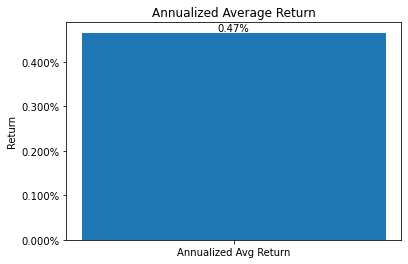

In [ ]:
plot_fun(annualized_avg_return)

### Carbon emisions

In [ ]:
# Let's get the carbon emission
total_carbon_op = co.mul(optimal_weightes_op, axis=1)

# Let's drop the first row since it's all NaN
total_carbon_op = total_carbon_op.dropna()

# Let's sum the whole column to get the total carbon footprint
carbon_f_y_op = total_carbon_op.sum(axis=1)

# Let's plot the Carbon Footprint
carbon_f_y_op.plot(title="Carbon Footprint w/o Carbon Emission Reductions")

# Portoflio with Carbon Constraints reduction of 30%

In [ ]:
# Create an empty dictionary to store results
results_dict_cc = {}

w = 2000
#Loop on dates (months 2014-2020)
for date in dates:
    
    #Define the objective function (minimum variance)
    objectiveFunction = lambda x: np.dot(x.T, np.dot(Covar.loc[date], x))
    
    #Set initial weights (equally weighted portfolio)
    numberOfAssets = len(returns_10a.columns)
    x0 = np.ones(numberOfAssets)/numberOfAssets 

    bounds = tuple((0,1) for x in range(numberOfAssets))

    #Define contraints:
    cons_s = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    # Let's apply the beta constraint depending on the year of that weight optimization
    
    # Define the inequality constraint for carbon emissions reduction
    target = 0.30
    co_date = total_carbon.loc[2013]
    co_ref=((x0*co_date)).sum()
    co_limit=(1-target)*co_ref
    co_constraint = LinearConstraint(co_date, 0, co_limit)
    # Let's add the constraint to the list of constraints
    cons=[cons_s, co_constraint]

    #Solve the optimization
    results_cc = minimize(objectiveFunction, x0, method='SLSQP', constraints=cons, bounds=bounds)
    
    # Extract relevant information
    success = results_cc.success
    optimal_weights = results_cc.x if success else None
    
    # Append results to the dictionary
    results_dict_cc[date] = {
        'Success': success,
        'Optimal Weights': optimal_weights,
        'Function Value': results_cc.fun
    }

In [ ]:
# Let's create a chart to see the evolution of the function value
# Create a DataFrame from the dictionary
results_df_cc = pd.DataFrame.from_dict(results_dict_cc, orient='index')

# Let's see the weighted with the lowest function value
optimal_weightes_cc = results_df_cc['Optimal Weights'].iloc[0]

optimal_weightes_cc

array([0.12768119, 0.25195825, 0.        , 0.41383519, 0.20652537])

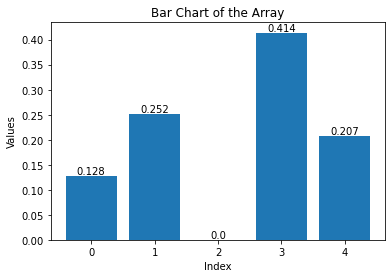

In [ ]:
fig, ax = plt.subplots()
bars = ax.bar(range(len(optimal_weightes_cc)), optimal_weightes_cc)

# Add labels, title, and grid
ax.set_ylabel('Values')
ax.set_xlabel('Index')
ax.set_title('Bar Chart of the Array')
ax.grid(False)

# Display the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()

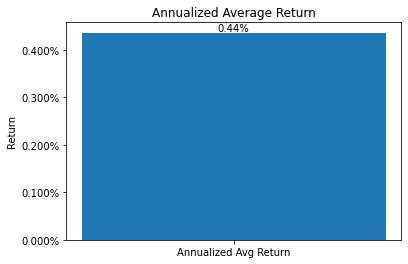

In [ ]:
# Now let's multiply the weights by the returns
optimal_returns_cc = returns_10a.mul(optimal_weightes_cc, axis=1)

# Let's sum the returns over time
optimal_returns_cc = optimal_returns_cc.median(axis=1)

# Annualized average return
annualized_avg_return_cc = np.nanmean(optimal_returns_cc) * 12

plot_fun(annualized_avg_return_cc)

### Carbon emissions with the constraints

In [ ]:
# Let's get the carbon emission
total_carbon_cc = co.mul(optimal_weightes_cc, axis=1)

# Let's drop the first row since it's all NaN
total_carbon_cc = total_carbon_cc.dropna()

# Sum the whole column to get the total carbon footprint
carbon_f_y_cc = total_carbon_cc.sum(axis=1)

# Plot the Carbon Footprint
carbon_f_y_cc.plot(title="Carbon Footprint with Carbon Emission Reductions 30%")